# K-Nearest Neighbors algorithm for classification

Here I'll be constructing the K-Nearest Neighbor (KNN) algorithm from scratch to make a classification. At the end, I'll also see how to use the library from scikit-learn to implement KNN.

### Overview

I'll use a data set to classify whether a patience have breast cancer os not given some features.

### The data

I'll be using the data kindly provided by UCI Machine Learning Repository that can be found here:https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+%28Diagnostic%29 or here: https://www.kaggle.com/uciml/breast-cancer-wisconsin-data

The data consist of 569 samples and 30 features with a binary target named with 'M', that stands for malignant (the patience have cancer) and 'B', that stands for benign (the pacience does not have a harmful cancer).

### Let's start!

## Checking and cleaning the data

Having the data downloaded in a .csv file, let's take see how the data looks. Remembering to import the desired libraries

In [42]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

df = pd.read_csv('data.csv')
print(df.head())
print(df.columns)

         id diagnosis  radius_mean  texture_mean  perimeter_mean  area_mean  \
0    842302         M        17.99         10.38          122.80     1001.0   
1    842517         M        20.57         17.77          132.90     1326.0   
2  84300903         M        19.69         21.25          130.00     1203.0   
3  84348301         M        11.42         20.38           77.58      386.1   
4  84358402         M        20.29         14.34          135.10     1297.0   

   smoothness_mean  compactness_mean  concavity_mean  concave points_mean  \
0          0.11840           0.27760          0.3001              0.14710   
1          0.08474           0.07864          0.0869              0.07017   
2          0.10960           0.15990          0.1974              0.12790   
3          0.14250           0.28390          0.2414              0.10520   
4          0.10030           0.13280          0.1980              0.10430   

   ...  texture_worst  perimeter_worst  area_worst  smoothness

Our target column is the second columns. Let's pop that column to a new variable, and then substitute the labels 'M' for 1 and 'B' for 0. Also, seems like the last columns is not wanted. Let's get rid of the last column

In [2]:
df.drop(df.columns[-1], axis=1, inplace=True)
target = df.pop('diagnosis')
# target = target.apply(lambda x: 1 if x == 'M' else 0)
print(df.columns)

Index(['id', 'radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean',
       'smoothness_mean', 'compactness_mean', 'concavity_mean',
       'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean',
       'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se',
       'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se',
       'fractal_dimension_se', 'radius_worst', 'texture_worst',
       'perimeter_worst', 'area_worst', 'smoothness_worst',
       'compactness_worst', 'concavity_worst', 'concave points_worst',
       'symmetry_worst', 'fractal_dimension_worst'],
      dtype='object')


In [3]:
print(target.value_counts())

B    357
M    212
Name: diagnosis, dtype: int64


Check if  there is any missing value in our data frame

In [4]:
if df.isna().any().any():
    print('Seems like there are some missing values in the dataset')
    print('There are {} missing values'.format(df.isna().sum().sum()))
else: 
    print('The data has no missing values')

The data has no missing values


Nice, there is no missing values in our data set! Now we shall proceed with the KNN algorithm

## Distances

The KNN algorithm is all about finding distances of an object from its neighbors. Let's write some functions to compute commonly used distances 

### Euclidean distance

Probably the most well known distance. For more information about Euclidean distance, check: https://en.wikipedia.org/wiki/Euclidean_distance

In [5]:
def euclidean_distance(pt1, pt2):
  '''
  This function takes two lists as parameters and computes the Euclidean distance between the two objects.
  Each element in a list represents one coordinate of the respective vector. 
  
  Returns a number representing the distance between the two vectors given as arguments
  '''
  return sum([(a - b) ** 2 for [a, b] in zip(pt1, pt2)]) ** 0.5
 

### Manhattan distance

Very similar to the Euclidean distance. However, instead of summing the squared difference between the coordinates of the vector, we sum the absolute diference between the coordinates. For more information about the Manhattan distance, check: https://en.wikipedia.org/wiki/Taxicab_geometry

P.S.: in scikit-learn, the Manhattan distance is refered as cityblock distance

In [6]:
def manhattan_distance(pt1, pt2):
  '''
  This function takes two lists as parameters and computes the Manhattan distance between the two objects.
  Each element in a list represents one coordinate of the respective vector. 
  
  Returns a number representing the distance between the two vectors given as arguments
  '''
  return sum([abs(a - b) for [a, b] in zip(pt1, pt2)])

### Hamming distance

Another formula to calculate distances. The Hamming distance cares only about if the coordinates of two vectors are the same. The hamming distance adds one to every similar coordinates shared by two vectors. The Hamming distance is usualy used to check spelling. For more information about the Hamming distance, check: https://en.wikipedia.org/wiki/Hamming_distance

In [7]:
def hamming_distance(pt1, pt2):
  '''
  This function takes two lists as parameters and computes the Hamming distance between the two objects. 
  
  Returns a number representing the distance between the two vectors given as arguments
  '''
  return sum([1 if a != b else 0 for [a, b] in zip(pt1, pt2)])


## Normalization

It is of major inportance to normalize the features in order to use the KNN algorithm. We will be exploring two kinds of normalization, viz. the min-max normalization and the z-score normalization. 

It is up to you to decide which kind of normalization is best suited for your application. In a nutshell, the min-max normalization will scale all features to the same scale, however it does not perform nicely with outliers; the z-score normalization can handle better outliers, however it may not normalize all features to the same scale

For more information about the normalization explored here, check: https://en.wikipedia.org/wiki/Feature_scaling

#### Min-Max normalization

In [8]:
def min_max_normalize(lst):
  '''
  This function take a list as a parameter and returns a list with the normalized values based on the Min-Max 
  normalization
  '''
  maximum, minimum = max(lst), min(lst)
  return [(i-minimum)/(maximum - minimum) for i in lst]
  

#### Z-score normalization 

In [9]:
def z_score_normalize(lst):
  '''
  This function ake a list as a parameter and returns a list with the normalized values based on the Z-score 
  normalization
  '''
  mean, sig = np.mean(lst), np.std(lst)
  return [ (i - mean) / sig for i in lst]

## KNN algorithm 

For more information about the k-nearest neighbors algorithm, check: https://en.wikipedia.org/wiki/K-nearest_neighbors_algorithm

### Selecting the features and normalizing

We are going to use only 10 features out of the 30. Let's choose the columns that represents the features's mean and save that to a variable called features

In [10]:
features = df[df.columns[1:11]]
print(features.head())

   radius_mean  texture_mean  perimeter_mean  area_mean  smoothness_mean  \
0        17.99         10.38          122.80     1001.0          0.11840   
1        20.57         17.77          132.90     1326.0          0.08474   
2        19.69         21.25          130.00     1203.0          0.10960   
3        11.42         20.38           77.58      386.1          0.14250   
4        20.29         14.34          135.10     1297.0          0.10030   

   compactness_mean  concavity_mean  concave points_mean  symmetry_mean  \
0           0.27760          0.3001              0.14710         0.2419   
1           0.07864          0.0869              0.07017         0.1812   
2           0.15990          0.1974              0.12790         0.2069   
3           0.28390          0.2414              0.10520         0.2597   
4           0.13280          0.1980              0.10430         0.1809   

   fractal_dimension_mean  
0                 0.07871  
1                 0.05667  
2       

Now, let's normalize all columns with the min-max normalization

In [11]:
features = features.apply(min_max_normalize)
print(features.head())

   radius_mean  texture_mean  perimeter_mean  area_mean  smoothness_mean  \
0     0.521037      0.022658        0.545989   0.363733         0.593753   
1     0.643144      0.272574        0.615783   0.501591         0.289880   
2     0.601496      0.390260        0.595743   0.449417         0.514309   
3     0.210090      0.360839        0.233501   0.102906         0.811321   
4     0.629893      0.156578        0.630986   0.489290         0.430351   

   compactness_mean  concavity_mean  concave points_mean  symmetry_mean  \
0          0.792037        0.703140             0.731113       0.686364   
1          0.181768        0.203608             0.348757       0.379798   
2          0.431017        0.462512             0.635686       0.509596   
3          0.811361        0.565604             0.522863       0.776263   
4          0.347893        0.463918             0.518390       0.378283   

   fractal_dimension_mean  
0                0.605518  
1                0.141323  
2       

We can see that our features are normalized. Nice! Now we are ready to calculate distances. 

### Splitting our data

Here we are going to use the scikit-learn function to split our data into train and test data. We will use 1/3 of our data for the test. 

For more information about this function, check: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

In [12]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.33, random_state=42)

### Find the k nearest neighbors

Here we will use one of the distance functions to find the k nearest neighbors.

Remember that each row in our dataset represents one element. For instance, lets see how the first instance from our test set looks like. We take the first row in the test set

In [13]:
first = X_test.iloc[0]
first_label = y_test.iloc[0]
print(first)
print(first_label)

radius_mean               0.259785
texture_mean              0.300643
perimeter_mean            0.257757
area_mean                 0.143542
smoothness_mean           0.424483
compactness_mean          0.265076
concavity_mean            0.187559
concave points_mean       0.189911
symmetry_mean             0.436869
fractal_dimension_mean    0.290017
Name: 204, dtype: float64
B


Now, let's write a function that, given one instance, will return the k nearest neighbors from our training set

In [14]:
def k_neighbors(unknown, train_set, k, distance_fun):
    '''
    This function will return a list of lists. Each element of a list (namely, another list), have 2 elements: 
    the distance between the elements and the index of the respective element from the training set. 
    
    For exemple: we will feed the function with one point (variable 'unknown'). The function will then calculate the 
    distance from 'unknown' to all of the items in the training set. In the for loop, a list 'neighbors' will be created
    with the distance from 'unknown' to the i-th row of the training set. Obviously, right after the for loop, 
    the list 'neighbors' is sorted by the indexes. But we want to sort by the distances! This is done with the 
    next instruction 'neighbors.sort()'
    
    The function will have as arguments:
        -> unknown : the point from where I want to calculate the distance from it to all the other points from training set
        -> train_set : the features from the training set
        -> k : number of neighbors
        -> fun : the function that calculates the distance, e.g. euclidean_distance(), etc
    '''
    neighbors = []
    for i in range(len(train_set)):
        neighbors.append([distance_fun(unknown, train_set.iloc[i]), i])
    neighbors.sort()
    return neighbors[:k]

In [15]:
print(k_neighbors(first, X_test, 10, euclidean_distance))

[[0.0, 0], [0.1081129182465027, 21], [0.11842369504905956, 69], [0.14770267494741063, 42], [0.15322710632214903, 136], [0.15464416857743077, 48], [0.16405411386054794, 124], [0.17386576269374462, 91], [0.18063047224943024, 180], [0.18489976844394124, 60]]


Now that we have the k neighbors, it's time to classify the point, viz. is he benign or malign?

Let's see an example. lets find the 20 closest neighbors from our first case in y_test dataset

In [16]:
# fetch the neighbors
list_neighbors = k_neighbors(first, X_train, 20, euclidean_distance)
# retrieve the indexes from the neighbors
list_indexes = [item[1] for item in list_neighbors]
# let's see the if the neighbors are majority benign or malign
print(y_train.iloc[list_indexes])

216    B
160    B
383    B
423    B
200    B
266    B
515    B
356    B
154    B
106    B
340    B
292    B
301    B
44     M
502    B
483    B
99     M
488    B
143    B
96     B
Name: diagnosis, dtype: object


Most of the neighbors are benign. So, it's probably a good idea to classify him as benign.

Let's write a function that will make that decision for us!

In [17]:
def classify (unknown, dataset, labels, k):
    # let's get the k-neighbors from our unknown
    neighbors = k_neighbors(unknown, dataset, k, euclidean_distance)
    indexes = [item[1] for item in neighbors]
    neighbors_labels = labels.iloc[indexes]
    
    num_M = len( [label for label in neighbors_labels if label == 'M'] )
    num_B = len( [label for label in neighbors_labels if label == 'B'] )

    # now that we have the number of benign and malign cases from the neighbors, we shall return
    # 'B' if most of neighbors are benign and 'M' if most are Malign
    # If num_B == num_M, then we return the label from the closest neighbor
    if num_B > num_M:
        return 'B', num_B, num_M
    elif num_M > num_B:
        return 'M', num_B, num_M
    else: 
        return neighbors_labels.iloc[0], num_B, num_M

In [18]:
predict, num_B, num_M = classify (first, X_train, y_train, 10)
if predict == 'M':
    prediction = 'malign'
else:
    prediction = 'benign'
print('We predicted that the case is {}, since we have {} benign neighbors and {} malign neighbors'.format(prediction, num_B, num_M))

We predicted that the case is benign, since we have 10 benign neighbors and 0 malign neighbors


That's it! We performed the KNN algorithm and predicted if the unknown case cancer is benign or malign!

## How good is our KNN algorithm?

Now it's time to test the accuracy of our algorithm. Let's see how many predictions are similar to the actual cases. We are going to test all cases that didn't participate in the training algoritm, namely the 'X_test' data set and their respective labels stored in 'y_test' 

Now, we would like to classify all of rows from X_test. For now, let's run the algorithm for 7 neighbors.

In [40]:
predict_labels = []
for i in range(len(X_test)):
    predict_labels.append(classify(X_test.iloc[i], X_train, y_train, 7)[0])

Now that we have a list of predictions, let's compare with the actual diagnosis

In [41]:
correct_predictions = sum( [1 if a == b else 0 for a, b in zip(predict_labels, y_test)] )
correct_pct = correct_predictions / len(y_test)

print('We correctly predicted {} out of {} with an accuracy of {:.1f}%'.format(correct_predictions, len(y_test), correct_pct*100))

We correctly predicted 177 out of 188 with an accuracy of 94.1%


## How to choose the best k?

Choosing the best k neighbors will influence in how well our algorithm will perform. But how to chose the best number of neighbors? We can actually make a plot of accuracy X number of neighbors. This way we can see what will be the best k for our problem. Let's just do that. Run the next cell, but it might take a few minutes

In [47]:
k = range(1, 30)
total = len(y_test)
accuracy = []

for num_neighbors in k:
    predict_labels = []
    for i in range(len(X_test)):
        predict_labels.append(classify(X_test.iloc[i], X_train, y_train, num_neighbors)[0])
    correct_predictions = sum( [1 if a == b else 0 for a, b in zip(predict_labels, y_test)] )
    correct_pct = correct_predictions / total
    accuracy.append(correct_pct)

KeyboardInterrupt: 

Since it takes several minutes to run the above cell, I'll save the result below and plot the desired graph

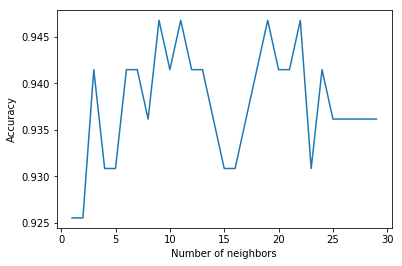

In [53]:
k = range(1, 30)
accu_list = [0.925531914893617, 0.925531914893617, 0.9414893617021277, 0.9308510638297872, 0.9308510638297872, 0.9414893617021277, 0.9414893617021277, 0.9361702127659575, 0.9468085106382979, 0.9414893617021277, 0.9468085106382979, 0.9414893617021277, 0.9414893617021277, 0.9361702127659575, 0.9308510638297872, 0.9308510638297872, 0.9361702127659575, 0.9414893617021277, 0.9468085106382979, 0.9414893617021277, 0.9414893617021277, 0.9468085106382979, 0.9308510638297872, 0.9414893617021277, 0.9361702127659575, 0.9361702127659575, 0.9361702127659575, 0.9361702127659575, 0.9361702127659575]

plt.plot(k, accu_list )
plt.xlabel('Number of neighbors')
plt.ylabel('Accuracy')
plt.show()

Seems like we can get our best result with k = 9 neighbors. Other higher values might result in the same accuracy, but it will cost more computational efforts to run.

## Using Sci-kit learn library

Using functions from sci-kit learn library will reduce a lot of work. 

For more information about KNN from sklearn library, check: https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html

Let's first import the library

In [54]:
from sklearn.neighbors import KNeighborsClassifier

Now, let's build our classifier. Note that we set the number of neighbors on the next line:

In [56]:
classifier = KNeighborsClassifier(n_neighbors = 9) 

We already split our data, and have them already normalized (don't forget to normalize them), it's time to train the classifier. For that, we do the following:

In [57]:
classifier.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=9, p=2,
           weights='uniform')

Now, we can take our predictions. Let's classify our first row from the test dataset(stored in first)

In [63]:
print(classifier.predict([first]))

['B']


And, it classified correcly! The sklearn library has a method .score() to tell us how good is the classifier. 

In [65]:
print(classifier.score(X_test, y_test))

0.9468085106382979


And that's it. You can play with the code. For instance, what will be the best number k for neighbors? Which function will be the best to calculate the distance? What method should you use to normalize the data?